<a href="https://colab.research.google.com/github/AkhmadRamadani/PCVK-2025-PUBLIC/blob/main/UTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Akhmad Ramadani

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path = '/content/drive/MyDrive/PCVK/UTS/'

# Images list
file_data1 = base_path + 'gelap.JPG' # Dalam ruangan minim cahaya
file_data2 = base_path + 'terang.JPG' # Di bawah lampu terang
file_data3 = base_path + 'dekat_jendela.JPG' # Di samping jendela

files = [file_data1, file_data2, file_data3]
titles = ['Data 1 (Gelap)', 'Data 2 (Terang)', 'Data 3 (Samping Jendela)']

In [4]:
def show_image_and_hist(img_path, title):
    img = cv.imread(img_path, cv.IMREAD_COLOR)
    if img is None:
        print(f"Error: Gagal membaca gambar di {img_path}")
        return False

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(title, fontsize=16)

    # Menampilkan Gambar
    ax1.imshow(gray, cmap='gray')
    ax1.set_title('Gambar Grayscale')
    ax1.axis('off')

    # Menampilkan Histogram
    ax2.hist(gray.ravel(), 256, [0, 256], color='blue')
    ax2.set_title('Histogram Intensitas')
    ax2.set_xlabel('Intensitas (0-255)')
    ax2.set_ylabel('Jumlah Piksel')
    ax2.set_xlim([0, 256])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return True

In [25]:
def process_image_pipeline(img_path, title):
    """
    Memproses gambar menggunakan Linear BC, Log Transform, HE, Low-pass, High-pass, Gabungan, dan Dithering.
    """
    img_color = cv.imread(img_path, cv.IMREAD_COLOR)
    if img_color is None:
        print(f"Gagal memuat {img_path} untuk pipeline")
        return

    # Tahap 1: Gambar Asli (Grayscale)
    img_asli = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)

    # --- Tahap A.3: Transformasi Brightness & Contrast ---

    # 3a. Transformasi Linear
    if 'Gelap' in title:
        a = 1.8
        b = 50
    elif 'Terang' in title:
        a = 0.8
        b = -30
    else: # Samping Jendela
        a = 1.2
        b = 10

    img_bc_linear = cv.convertScaleAbs(img_asli, alpha=a, beta=b)

    # 3b. Transformasi Log (Log Brightness)
    img_asli_f32 = img_asli.astype(np.float32)
    c = 255 / np.log(1 + np.max(img_asli_f32))
    img_log = c * np.log(1 + img_asli_f32)
    img_log = np.clip(img_log, 0, 255).astype(np.uint8)


    # --- Tahap A.4: Histogram Equalization ---
    img_he = cv.equalizeHist(img_bc_linear)


    # --- Tahap A.5: Spatial Filtering (Dipecah) ---

    # 5a. Low-pass filter (menghaluskan noise)
    img_lp = cv.GaussianBlur(img_he, (5, 5), 0)

    # 5b. High-pass filter (Laplacian untuk menajamkan tepi)
    kernel_hp = np.array([[-1, -1, -1],
                          [-1,  8, -1],
                          [-1, -1, -1]])

    img_hp_raw = cv.filter2D(img_he, cv.CV_64F, kernel_hp)
    # Konversi ke uint8
    img_hp_display = cv.convertScaleAbs(img_hp_raw)

    # 5c. Gabungan (Unsharp Masking)
    img_filtered = cv.addWeighted(img_lp, 1.5, img_hp_display, -0.5, 0)

    # --- Tahap A.6: Dithering / Reduksi Bit-Depth ---
    N_BITS = 6
    shift = 8 - N_BITS
    # Kuantisasi: Geser bit ke kanan, lalu ke kiri
    img_dithered = (img_filtered >> shift) << shift

    results = [
        img_asli, img_bc_linear, img_log, img_he,
        img_lp, img_hp_display, img_filtered, img_dithered
    ]

    titles_steps = [
        '1. Asli (Gray)',
        f'2. Linear BC (a={a}, b={b})',
        '3. Log Transform',
        '4. Hist. Equalization (dari Linear BC)',
        '5. Low-Pass Filter (Blur)',
        '6. High-Pass Filter (Tepi)',
        '7. Gabungan Filter (Tajam)',
        f'8. Dithered ({N_BITS}-bit)'
    ]

    fig, axes = plt.subplots(4, 4, figsize=(20, 18))
    fig.suptitle(f"Pipeline Pemrosesan Lengkap: {title}", fontsize=20)

    for i in range(8):
        # Tentukan posisi di grid
        row_img = (i // 4) * 2  # Baris 0 untuk i=0-3, Baris 2 untuk i=4-7
        row_hist = row_img + 1  # Baris 1 untuk i=0-3, Baris 3 untuk i=4-7
        col = i % 4             # Kolom 0, 1, 2, 3

        # Tampilkan Citra
        ax_img = axes[row_img, col]
        ax_img.imshow(results[i], cmap='gray', vmin=0, vmax=255)
        ax_img.set_title(titles_steps[i], fontsize=12)
        ax_img.axis('off')

        # Tampilkan Histogram
        ax_hist = axes[row_hist, col]
        ax_hist.hist(results[i].ravel(), 256, [0, 256], color='blue')
        ax_hist.set_xlabel('Intensitas')
        ax_hist.set_xlim([0, 256])
        if col == 0:
            ax_hist.set_ylabel('Jumlah Piksel')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

In [26]:
def calculate_psnr(file_ref, file_dark):
    print("\n--- Menghitung PSNR (Bagian D.2) ---")
    img_ref_color = cv.imread(file_ref, cv.IMREAD_COLOR)
    if img_ref_color is None:
        print(f"Gagal memuat file referensi {file_ref}")
        return

    img_ref_gray = cv.cvtColor(img_ref_color, cv.COLOR_BGR2GRAY)

    img_dark_color = cv.imread(file_dark, cv.IMREAD_COLOR)
    if img_dark_color is None:
        print(f"Gagal memuat file gelap {file_dark}")
        return

    img_dark_gray = cv.cvtColor(img_dark_color, cv.COLOR_BGR2GRAY)

    a, b = 1.8, 50
    img_bc_dark = cv.convertScaleAbs(img_dark_gray, alpha=a, beta=b)
    img_processed_dark = cv.equalizeHist(img_bc_dark)

    if img_ref_gray.shape == img_processed_dark.shape:
        psnr_val = cv.PSNR(img_ref_gray, img_processed_dark)
        print(f"PSNR antara '{file_ref.split('/')[-1]} (Asli)' dan '{file_dark.split('/')[-1]} (Hasil Proses)' adalah: {psnr_val:.2f} dB")
    else:
        print("Ukuran gambar referensi dan gambar proses berbeda. Harap resize agar sama.")


Menganalisis Data 1 (Gelap) (File: gelap.JPG)


/tmp/ipython-input-4291151649.py:19: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax2.hist(gray.ravel(), 256, [0, 256], color='blue')


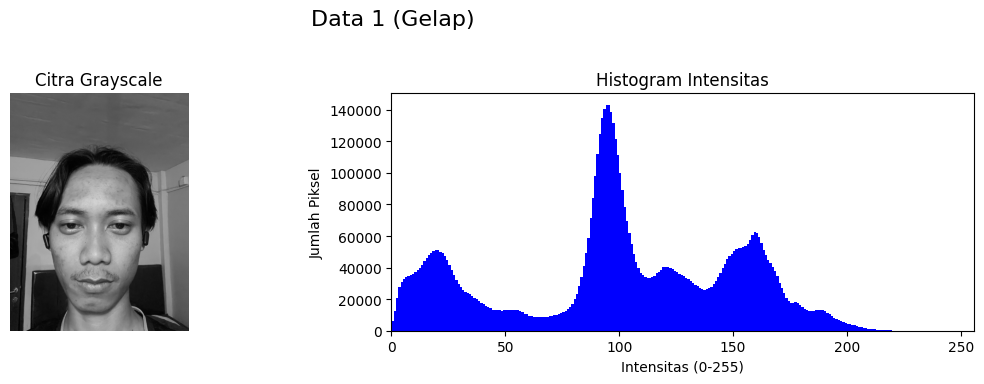


Menganalisis Data 2 (Terang) (File: terang.JPG)


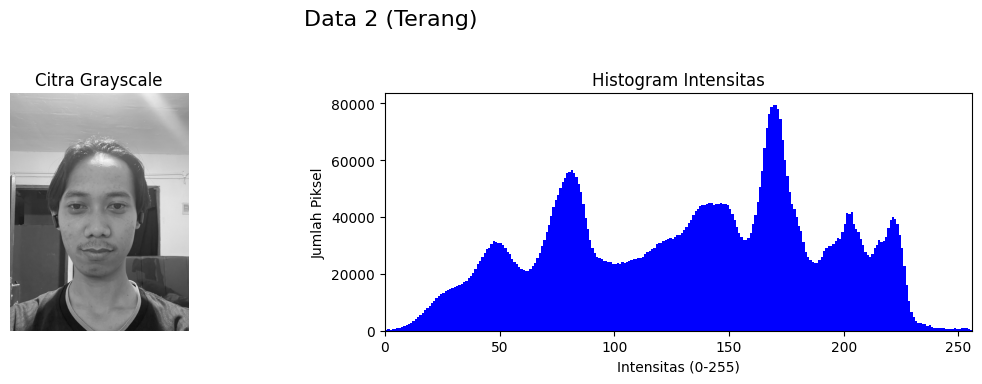


Menganalisis Data 3 (Samping Jendela) (File: dekat_jendela.JPG)


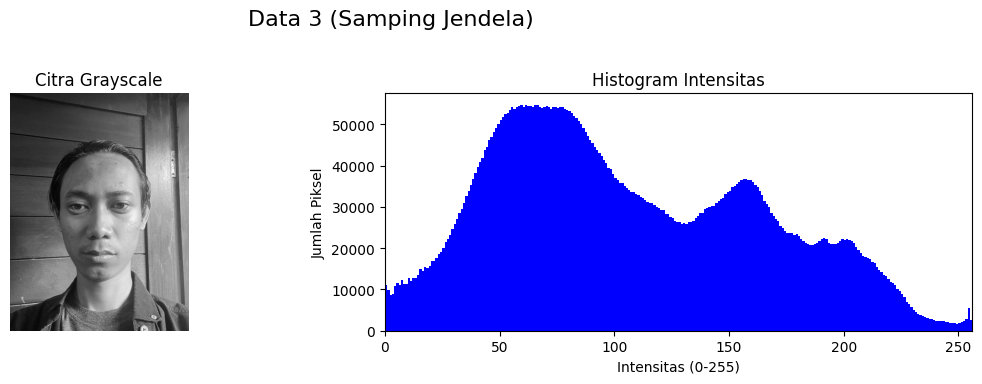


Memulai Pipeline untuk Data 1 (Gelap) (File: gelap.JPG)


/tmp/ipython-input-145651118.py:95: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  ax_hist.hist(results[i].ravel(), 256, [0, 256], color='blue')


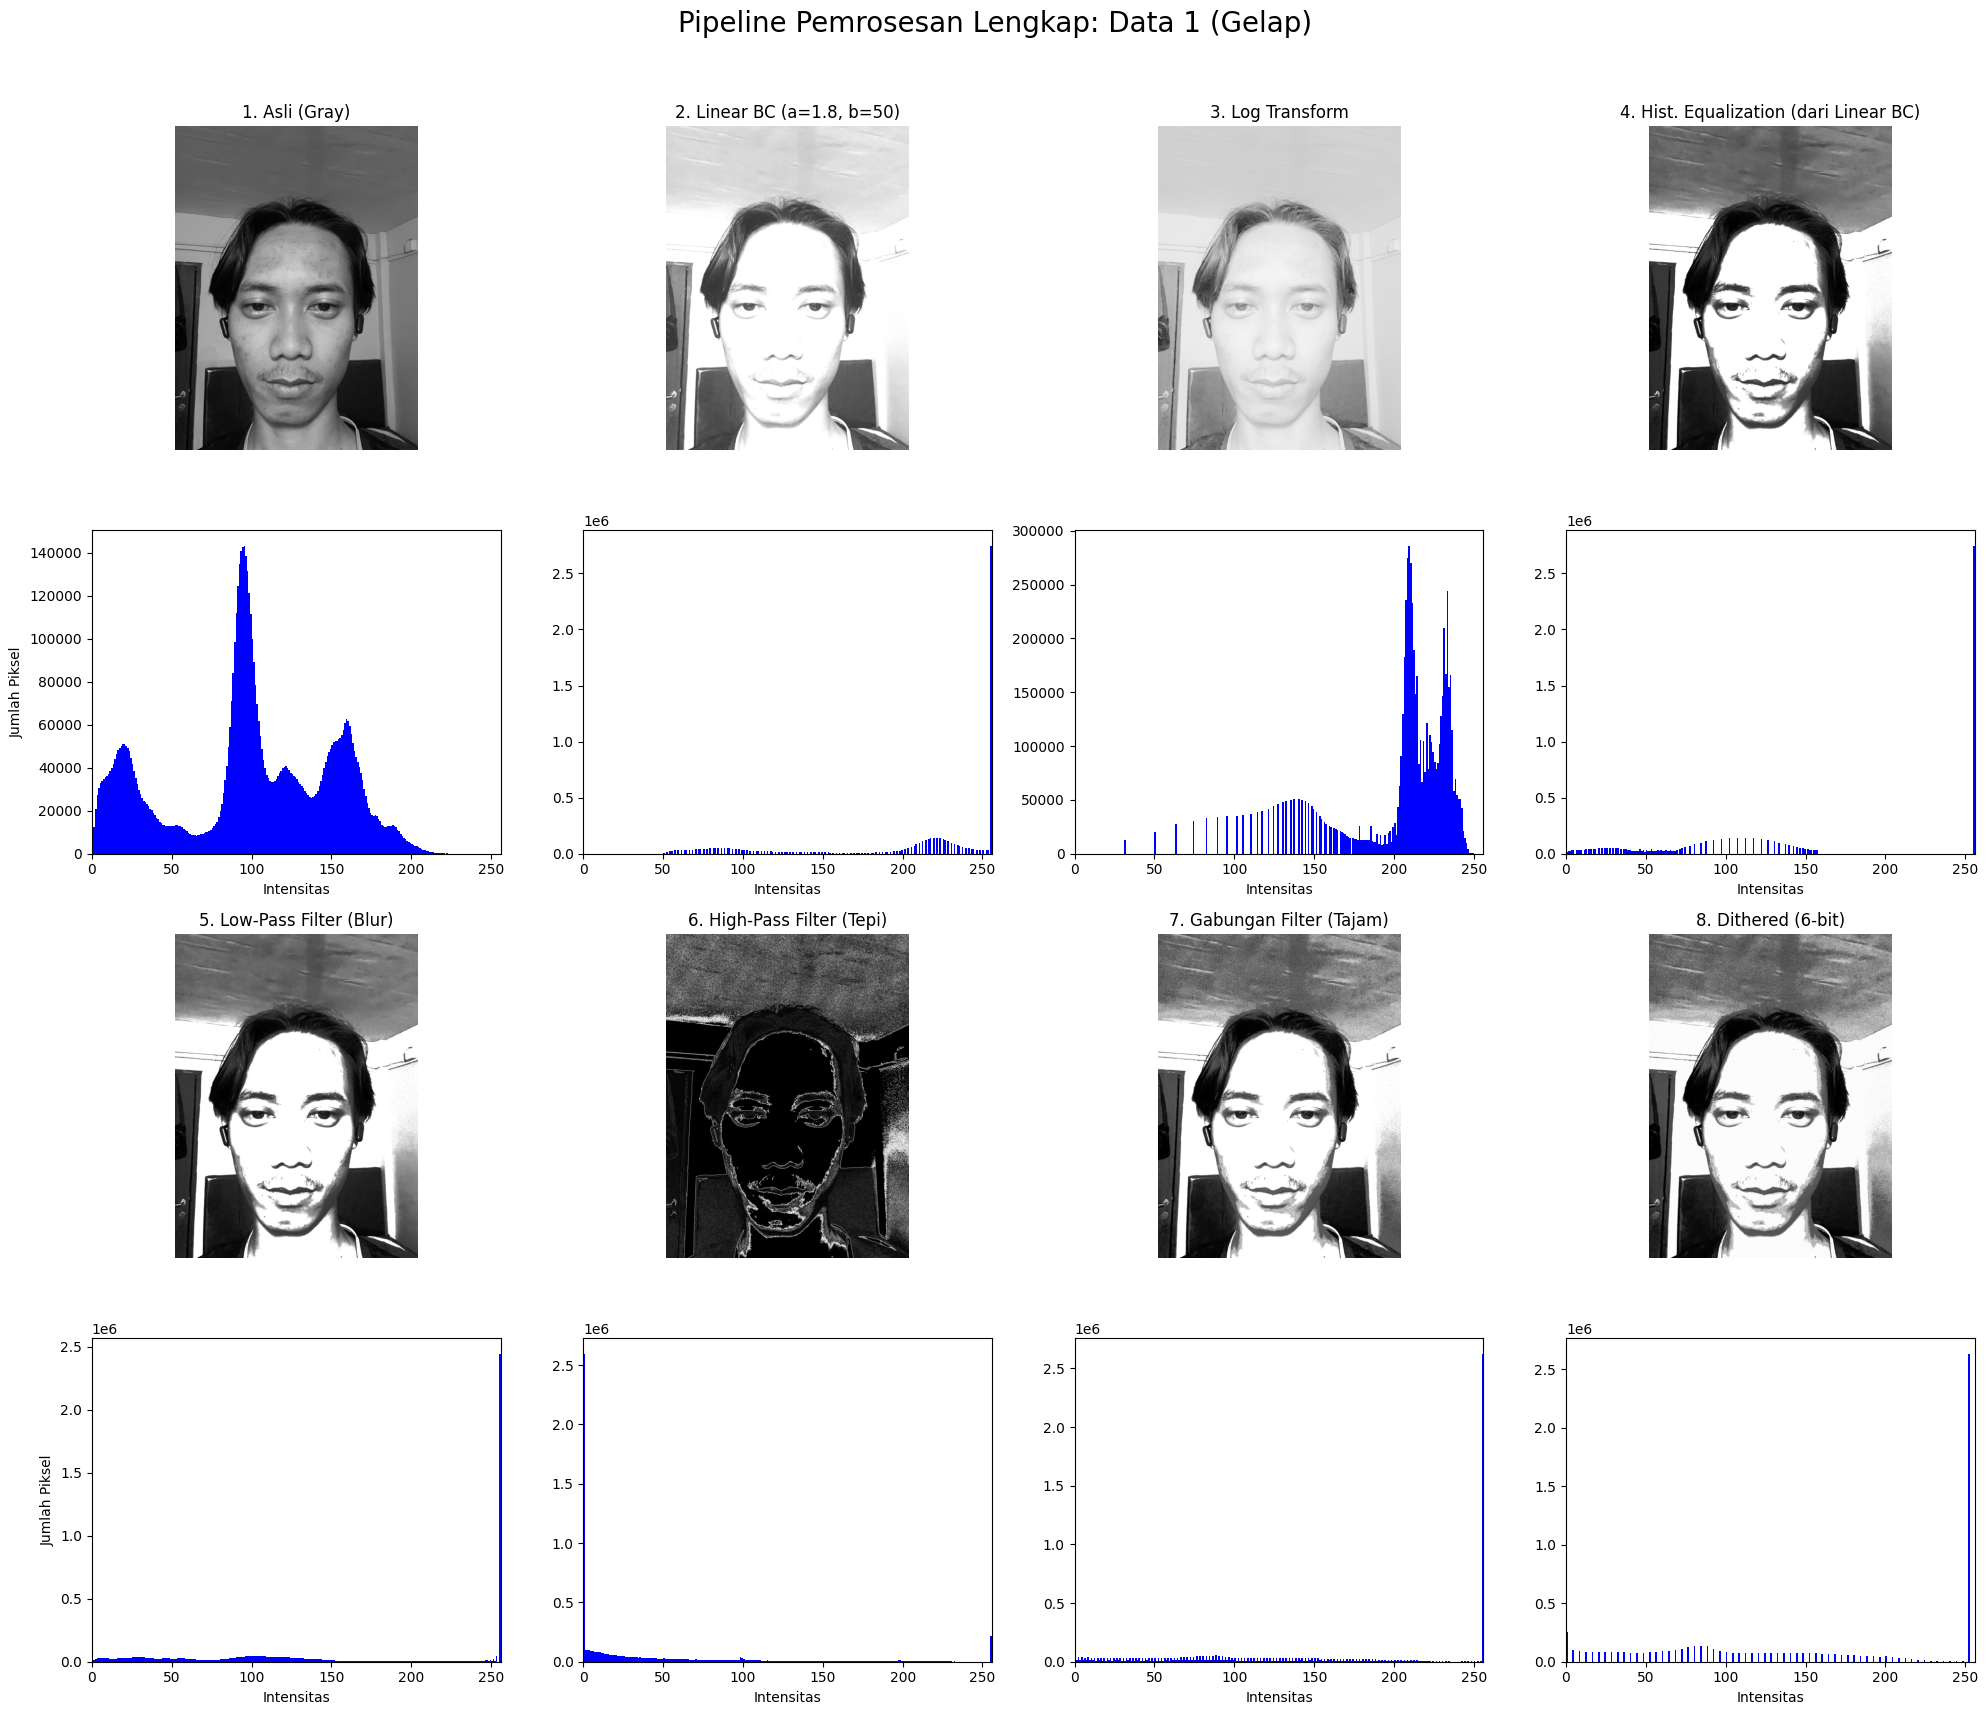


Memulai Pipeline untuk Data 2 (Terang) (File: terang.JPG)


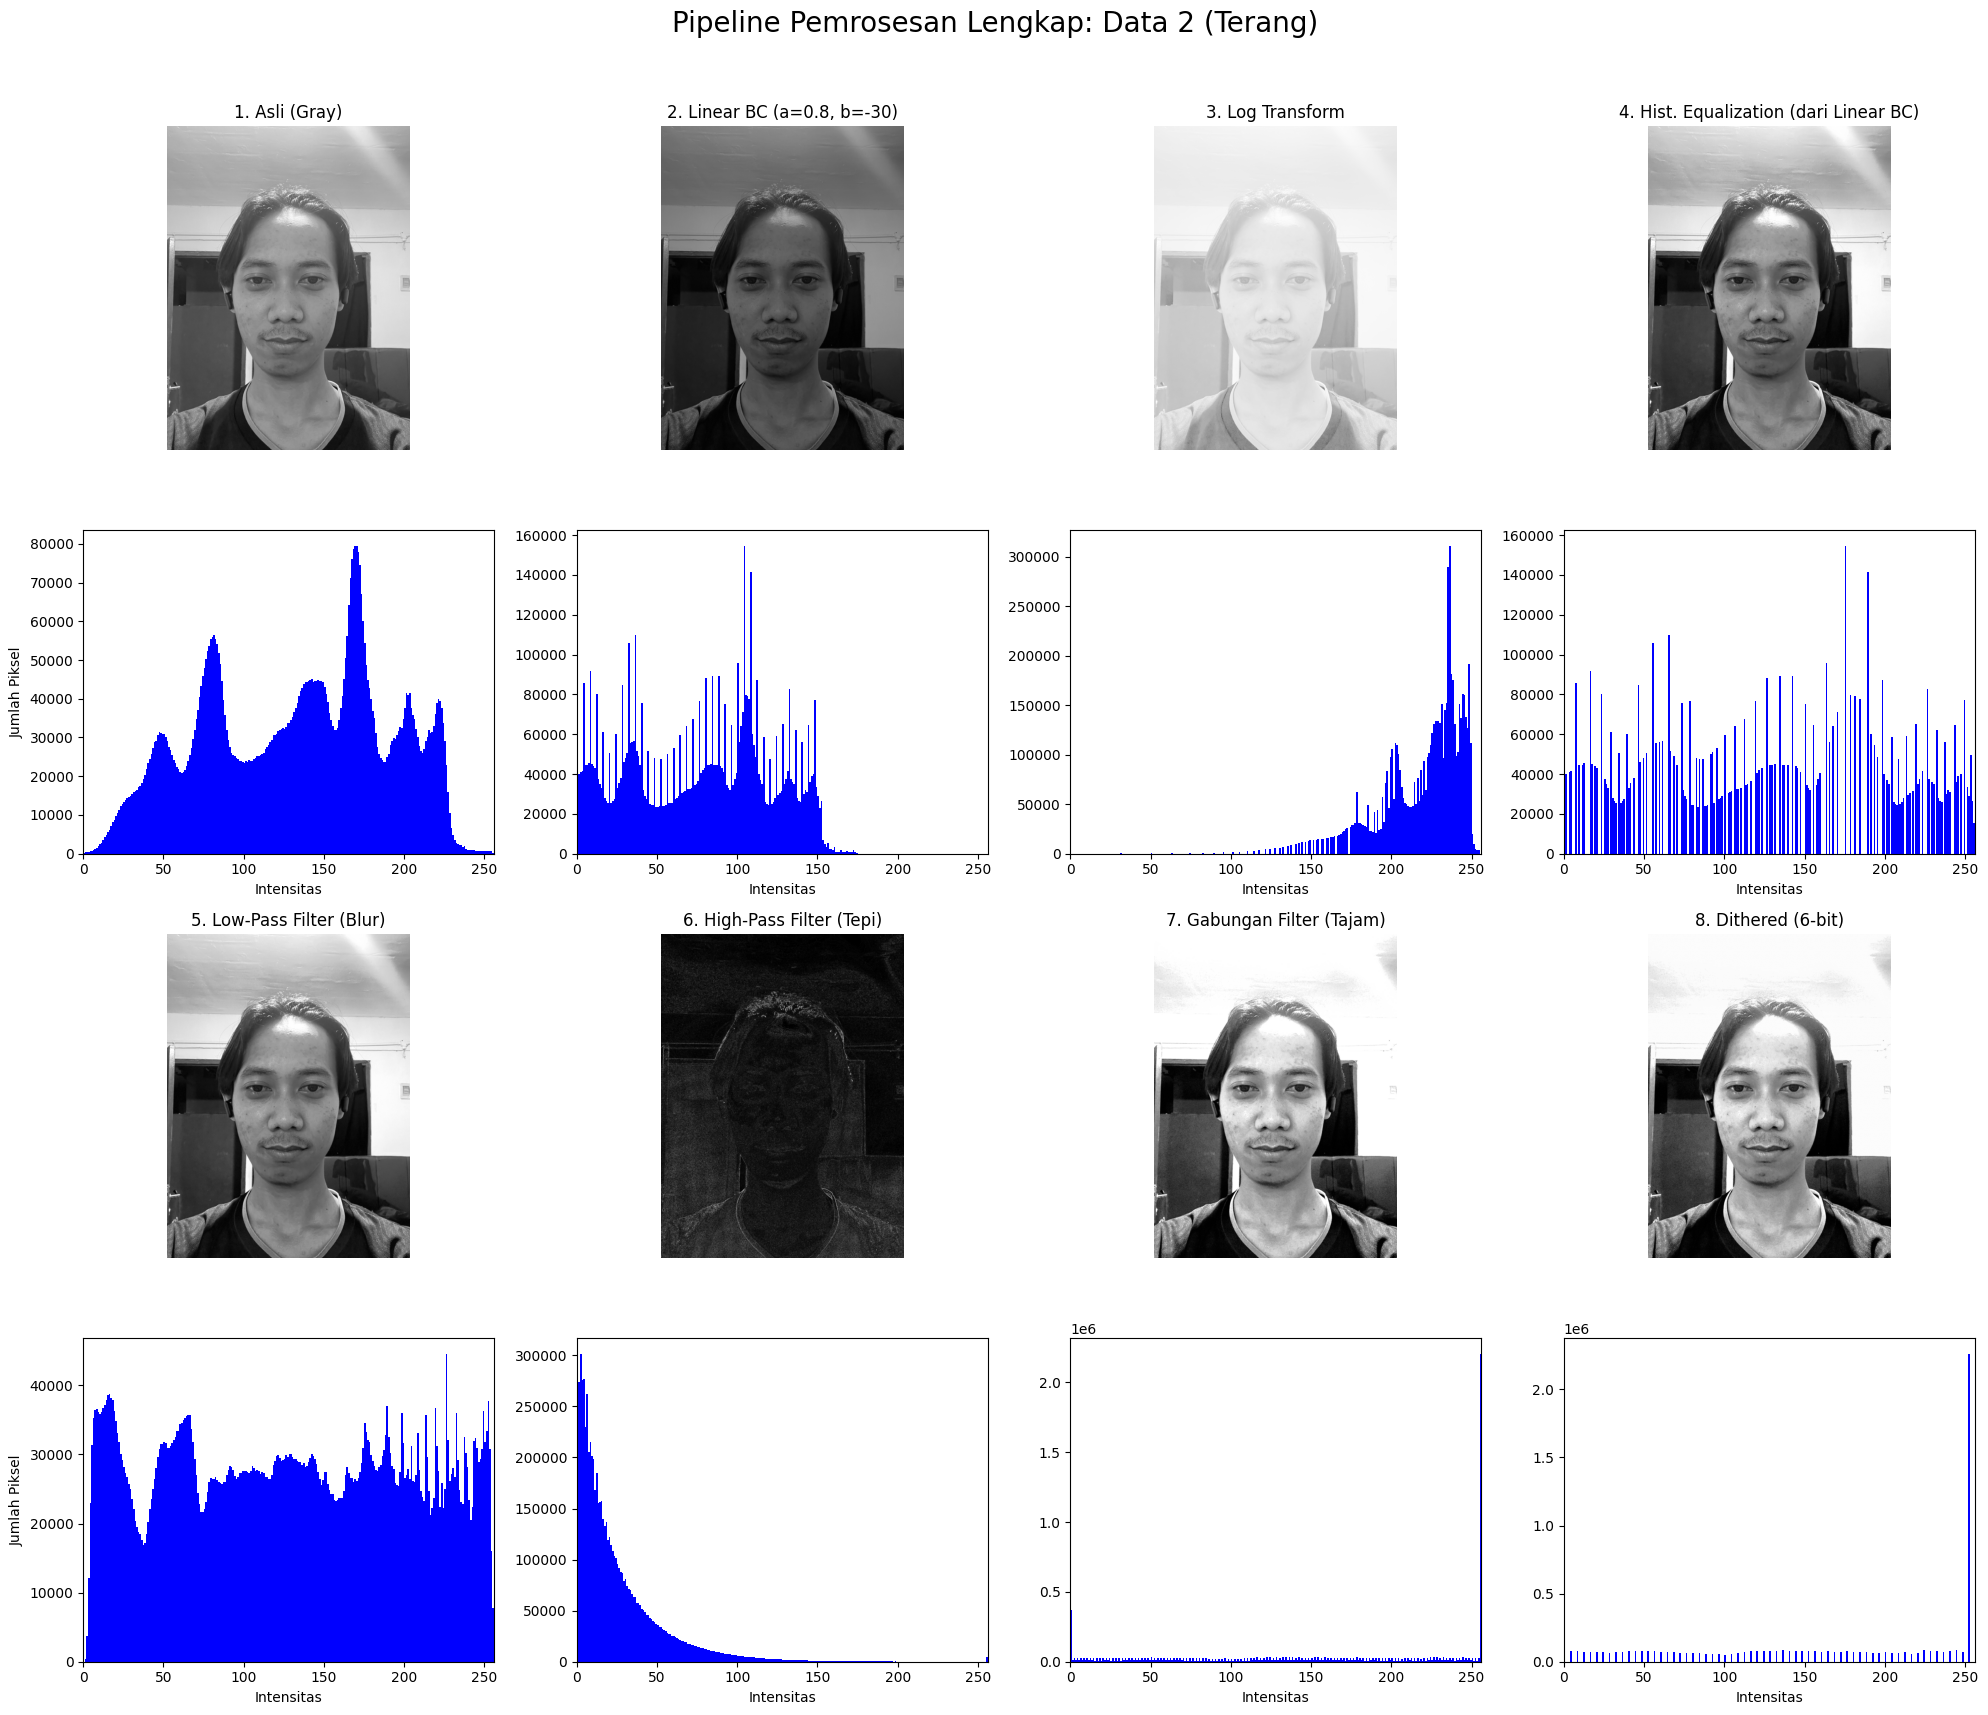


Memulai Pipeline untuk Data 3 (Samping Jendela) (File: dekat_jendela.JPG)


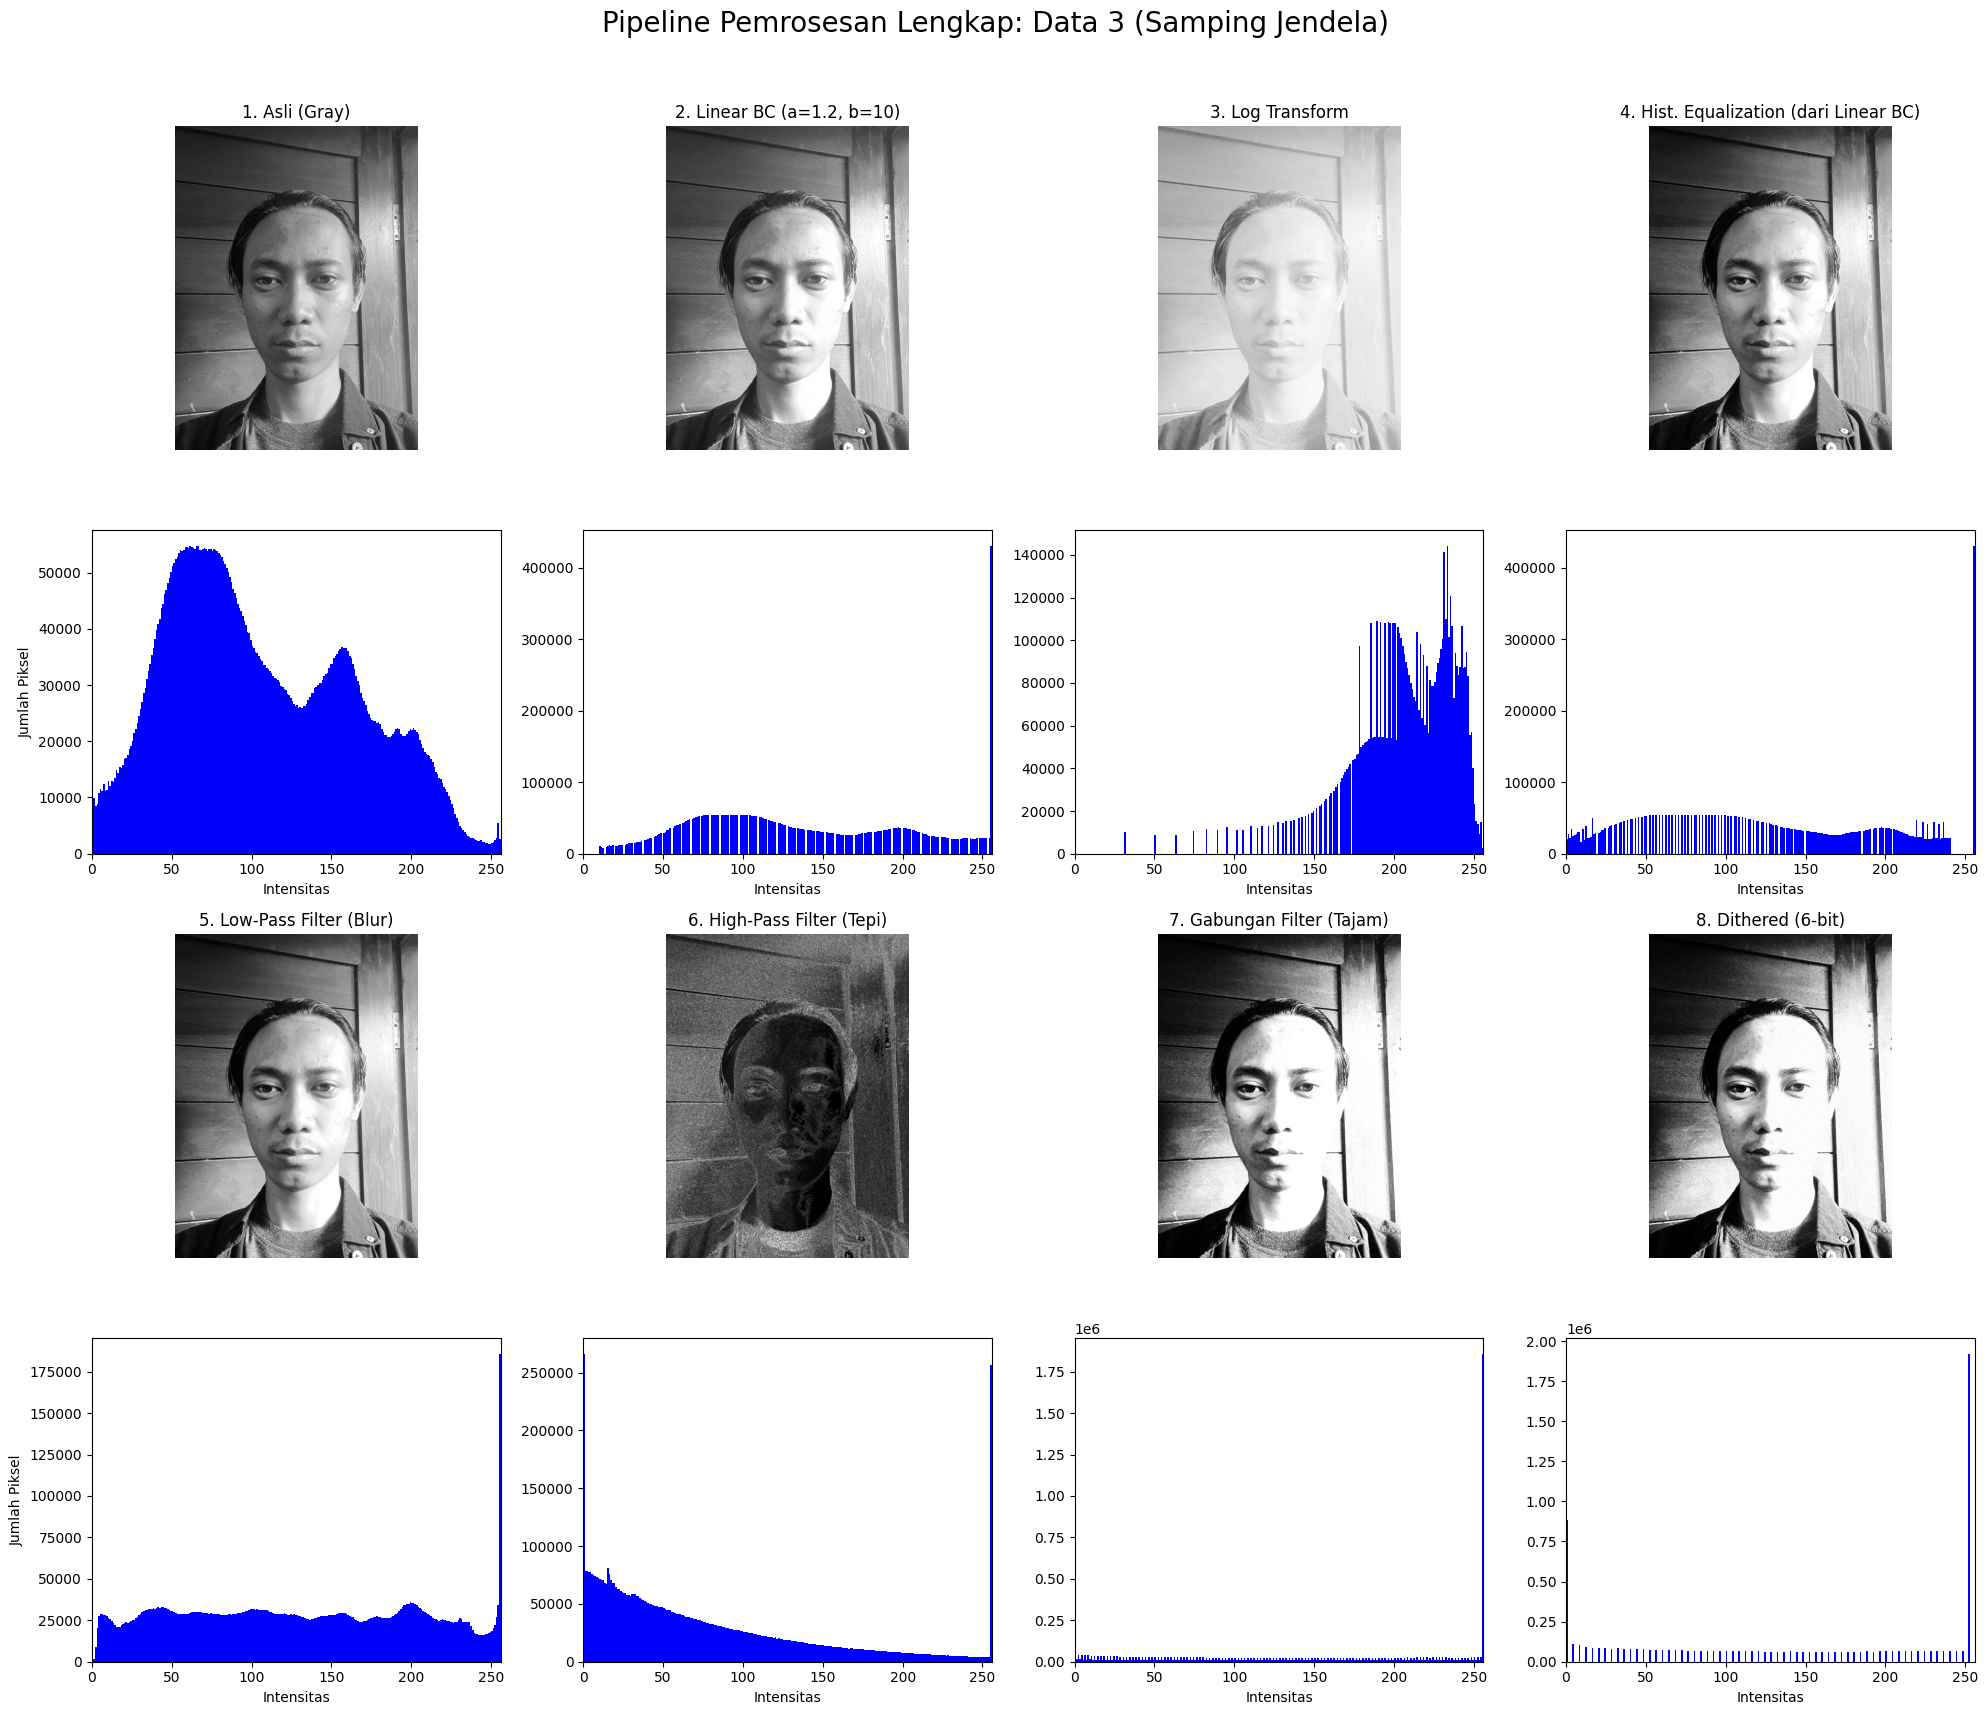


--- Menghitung PSNR (Bagian D.2) ---
PSNR antara 'terang.JPG (Asli)' dan 'gelap.JPG (Hasil Proses)' adalah: 8.21 dB

--- Eksekusi Selesai ---
Silakan isi template analisis (Bagian A.2, B, dan D) di sel Teks.


In [27]:
all_files_ok = True
for i, f in enumerate(files):
    print(f"\nMenganalisis {titles[i]} (File: {f.split('/')[-1]})")
    if not show_image_and_hist(f, titles[i]):
        all_files_ok = False

if all_files_ok:
    for i, f in enumerate(files):
        print(f"\n=======================================================")
        print(f"Memulai Pipeline untuk {titles[i]} (File: {f.split('/')[-1]})")
        print(f"=======================================================")
        process_image_pipeline(f, titles[i])

    calculate_psnr(file_data2, file_data1)
else:
    print("\nEksekusi dihentikan karena satu atau lebih file gambar gagal dibaca.")
    print("Harap periksa variabel 'base_path' dan nama file Anda di Google Drive.")

print("\n--- Eksekusi Selesai ---")
print("Silakan isi template analisis (Bagian A.2, B, dan D) di sel Teks.")


## Analisis Bagian B

### 1. Bagaimana perubahan nilai brightness dan contrast memengaruhi hasil histogram wajah/objek gelap?

Pada **Data 1 (Gelap)**, dapat dilihat bahwa:

* **Gambar Asli (Gambar 1):** Histogram asli terkonsentrasi di sisi kiri, intensitasnya rendah, lebih banyak yang di bawah 100, sehingga bisa disimpulkan bahwa gambar tersebut gelap.
* **Citra Linear BC (Gambar 2):** Setelah menerapkan *brightness* (`b=50`) dan *contrast* (`a=1.8`), histogramnya berubah drastis.
    * **Efek Brightness (b=50):** Seluruh piksel "digeser" lebih ke kanan. Sehinga membuat seluruh gambar menjadi lebih terang secara merata.
    * **Efek Contrast (a=1.8):** Histogramnya "direntangkan" (stretched). Piksel yang tadinya berdekatan (kontras rendah) kini dibuat agar melebar. Sehinga hal ini yang membuat rentang nilai piksel menjadi lebih lebar, lebih merata mulai dari 0 hingga 255.

Secara singkat, pada gambar gelap, peningkatan *brightness* menggeser histogram lebih ke kanan, dan peningkatan *contrast* melebarkan histogram agar memiliki rentang intensitas yang lebih luas.


### 2. Apakah histogram equalization selalu memperbaiki detail wajah/objek? Jelaskan alasannya dengan contoh hasil Anda.

**Tidak, histogram equalization (HE) tidak selalu memperbaiki detail.**

HE hanya akan meratakan distribusi intensitas. Ini berguna jika gambar memiliki kontras yang buruk, tapi bisa menjadi buruk jika gambar sudah memiliki rentang intensitas yang jauh.

* **Contoh Kegagalan (Data 1):** Pada **Data 1 (Gelap)**, citra "Linear BC" (Gambar 2) sudah memiliki histogram yang sangat lebar (terentang). Ketika HE diterapkan (Gambar 4), hasilnya menjadi *over-equalized*. Histogramnya menjadi sangat "tipis" dan tersebar, menghasilkan gambar yang sangat kasar, kehilangan banyak tekstur kulit, dan terlihat seperti posterisasi (posterized). Detail halus pada wajah justru **hilang**.
* **Contoh Keberhasilan (Data 2):** Pada **Data 2 (Terang)**, HE (Gambar 4) menghasilkan hasil yang baik. Hasil histogram yang tadinya miring ke kanan menjadi lebih seimbang, sehingga detail pada area yang lebih gelap menjadi lebih terlihat dan teksktur kulit juga lebih terlihat.

HE akan gagal ketika ia terlalu "memaksa" piksel yang sudah tersebar, yang akhirnya mengurangi detail, bukannya menambah detail halus.

### 3. Bandingkan hasil low-pass dan high-pass filter pada area wajah/objek bagian mana yang paling terpengaruh?

Berdasarkan perbandingan Gambar 5 (Low-Pass) dan Gambar 6 (High-Pass) di ketiga set data:

* **Low-Pass Filter (Blur):** Filter ini memengaruhi area dengan frekuensi tinggi atau **tekstur yang halus**. Pada wajah, area yang paling terpengaruh adalah **tekstur kulit (pori-pori), rambut halus, dan kerutan kecil**. Efeknya adalah menghaluskan atau memblurkan detail-detail tersebut.
* **High-Pass Filter (Tepi):** Filter ini melakukan kebalikan dari Low-Pass. Filter ini memengaruhi area dengan perubahan intensitas yang drastis, yaitu **tepi (edges)**. Pada wajah, area yang paling terpengaruh adalah **garis mata, alis, bibir, lubang hidung, dan garis rahang**. Area yang mulus (seperti pipi) menjadi hitam karena tidak ada perubahan intensitas.


### 4. Mengapa proses dithering bisa mempertegas atau justru mengaburkan ekspresi wajah/objek?

Dithering adalah teknik untuk mengurangi kedalaman bit (kuantisasi) tetapi mempertahankan persepsi visual kecerahan. Ini dilakukan dengan mengatur pola piksel dari warna-warna yang ada.

* **Mempertegas:** Dengan mengurangi jumlah level abu-abu, transisi antar bayangan menjadi lebih "kasar". Ini terkadang dapat *mempertegas* kontur atau garis besar fitur wajah (seperti senyuman atau kerutan dahi).
* **Mengaburkan:** Di sisi lain, proses dithering memasukkan *noise* (pola titik-titik) yang terlihat jelas seperti pada contoh Gambar Data 3 Image nomor 8. *Noise* ini dapat menghilangkan detail halus. Ekspresi wajah, seperti kedutan kecil di sudut mata atau sedikit lesung pipi, dapat hilang sehingga akan mengaburkan ekspresi aslinya.

### 5. Berdasarkan hasil percobaan Anda, kombinasi teknik mana yang paling efektif untuk meningkatkan readability fitur wajah sebelum tahap deteksi?

Berdasarkan ketiga pipeline, kombinasi yang paling efektif untuk *readability* (keterbacaan fitur) adalah:

**1. Penyesuaian Brightness/Contrast + 2. Sharpening (Penggabungan Filter)**

Alasannya:

* **Tahap 1: Penyesuaian Awal.** Diperlukan langkah untuk menormalkan pencahayaan. "Linear BC" (Gambar 2) atau "Log Transform" (Gambar 3) diharapkan Log Transform dapat melakukan lebih baik daripada Linear BC, namun pada percobaan kali ini Log Transform terlihat lebih pudar daripada Linear BC.

* **Tahap 2: Penajaman Fitur.** Langkah "Histogram Equalization" (Gambar 4) terbukti tidak dapat diandalkan karena gagal pada Data 1. Kegagalan ini sebenarnya karena contrast dan brightness yang saya naikkan terlalu tinggi. Sehingga histogram terlalu bergeser ke kanan. Karena saat saya coba menggunakan Brightness = 20, Contrast = 1.2, terlihat lebih baik. Kemudian pada "Low-Pass" (Gambar 5) menghilangkan detail. Dan "Dithered" (Gambar 8) menambah noise.

* **"Gabungan Low Pass dan High Pass" (Gambar 7)**  memberikan hasil baik, namun gagal pada gambar yang sumber cahayanya dari satu sisi seperti pada Contoh Data 3 Gambar 7. Detail pada sumber cahaya terkesan hilang. Namun langkah ini biasanya secara signifikan dapat **mempertegas tepi** mata, hidung, dan bibir yang merupakan fitur-fitur kunci untuk *face recognition*.

--- Menjalankan Analisis Visual Pipeline Real-Time ---
Memproses Data 1 (Gelap)...


/tmp/ipython-input-777748012.py:76: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  axes[1, 1].hist(face_roi_gray.ravel(), 256, [0, 256], color='blue', alpha=0.7, label='Asli (Crop)')
/tmp/ipython-input-777748012.py:77: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  axes[1, 1].hist(processed_face.ravel(), 256, [0, 256], color='red', alpha=0.7, label='Hasil Proses')


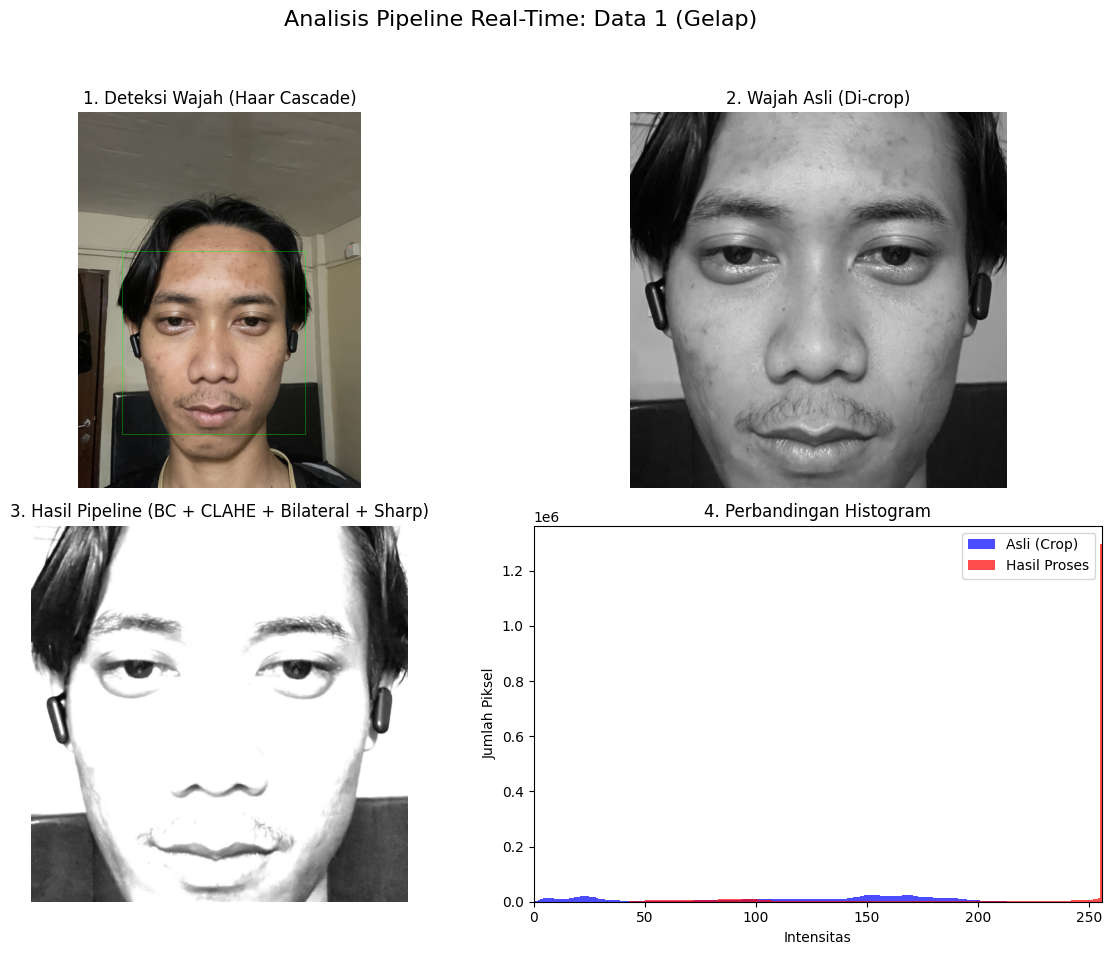

Memproses Data 2 (Terang)...


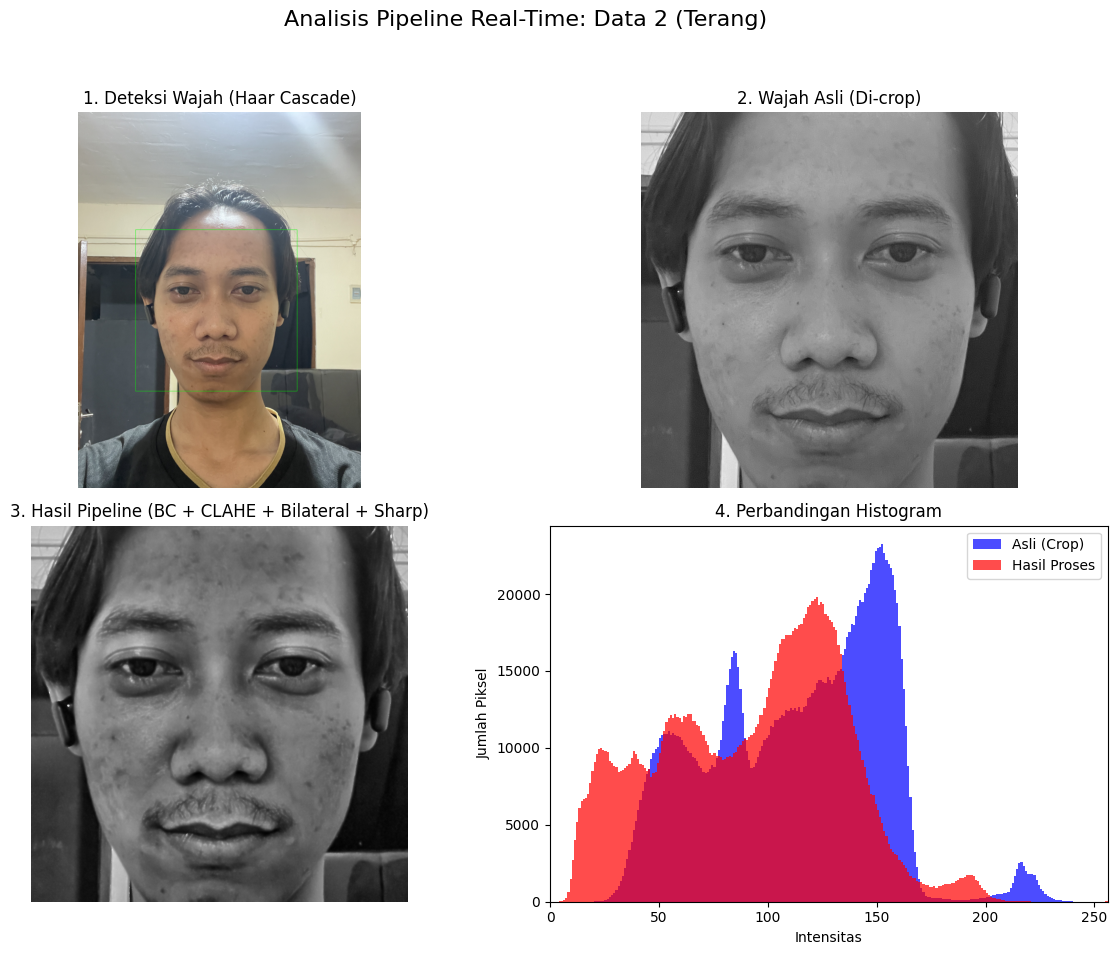

Memproses Data 3 (Sampling Jendela)...


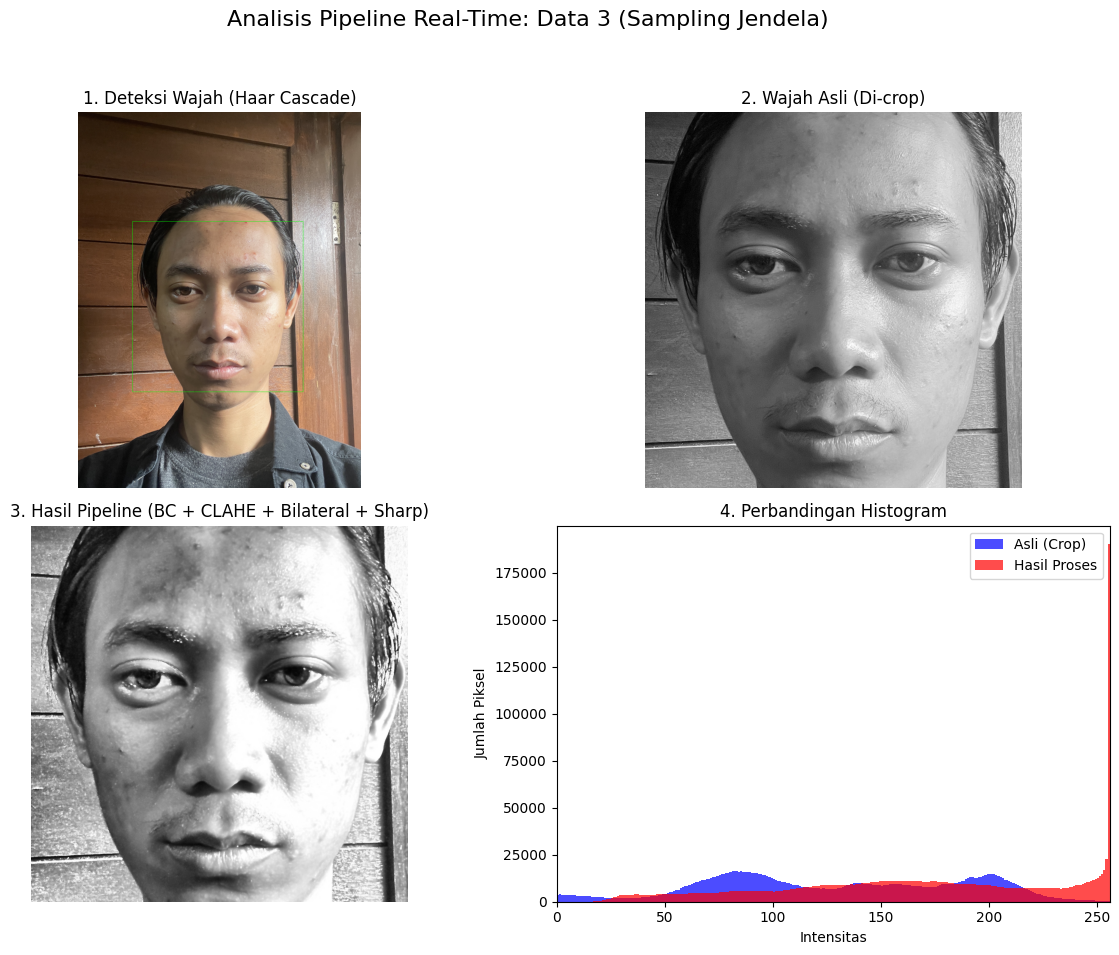


--- Analisis Kuantitatif PSNR ---
Gambar Referensi (Target): Data 2 (Terang)
-------------------------------------------------
| Gambar Uji           | PSNR (Sebelum)  | PSNR (Sesudah)  | Peningkatan |
|----------------------|-----------------|-----------------|------------|
| Data 1 (Gelap)       | 14.70           | 7.28            | -7.41      |
| Data 3 (Sampling Jendela) | 11.53           | 9.13            | -2.39      |


In [28]:
def get_best_params(title):
    """
    Menentukan parameter Linear BC berdasarkan judul/kondisi gambar.
    """
    if 'Gelap' in title:
        a = 1.8
        b = 50
    elif 'Terang' in title:
        a = 0.8
        b = -30
    else: # Samping Jendela
        a = 1.2
        b = 10
    return a, b

def run_processing_pipeline(face_roi_gray, a, b):
    """
    Menjalankan pipeline pemrosesan (BC, CLAHE, Bilateral, Sharpen)
    pada gambar wajah yang sudah di-crop.
    """
    # 1. Linear Brightness/Contrast
    img_bc = cv.convertScaleAbs(face_roi_gray, alpha=a, beta=b)

    # 2. CLAHE (Menggantikan HE global)
    # Karena CLAHE menurut
    # Artikel Studi Efek Ekualisasi Histogram dan CLAHE dalam Mendeteksi Fitur Wajah Manusia
    # oleh Regina Lionnie 2018 lebih baik dalam penggunaan untuk fitur wajah manusia
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_bc)

    # 3. Bilateral Filter (Menggantikan GaussianBlur untuk menghaluskan
    #    noise, tetapi tetap memperhatikan tepi/egdes)
    img_lp = cv.bilateralFilter(img_clahe, 9, 75, 75)

    # 4. Sharpening (Unsharp Masking)
    # sama seperti di atas
    kernel_hp = np.array([[-1, -1, -1],
                          [-1,  8, -1],
                          [-1, -1, -1]])
    img_hp_raw = cv.filter2D(img_lp, cv.CV_64F, kernel_hp)
    img_hp_display = cv.convertScaleAbs(img_hp_raw)

    img_final_sharp = cv.add(img_lp, img_hp_display)

    return img_final_sharp

def plot_analysis_comparison(img_color, face_bbox, face_roi_gray, processed_face, title):
    """
    Membuat plot perbandingan 4-panel untuk Analisis Akhir.
    """
    (x, y, w, h) = face_bbox

    # Buat gambar dengan bounding box
    img_with_box = cv.rectangle(img_color.copy(), (x, y), (x+w, y+h), (0, 255, 0), 2)
    img_with_box = cv.cvtColor(img_with_box, cv.COLOR_BGR2RGB) # Untuk plt

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Analisis Pipeline Real-Time: {title}", fontsize=16)

    # 1. Deteksi Wajah (Original + BBox)
    axes[0, 0].imshow(img_with_box)
    axes[0, 0].set_title("1. Deteksi Wajah (Haar Cascade)")
    axes[0, 0].axis('off')

    # 2. Wajah Asli (Hasil Crop)
    axes[0, 1].imshow(face_roi_gray, cmap='gray')
    axes[0, 1].set_title("2. Wajah Asli (Di-crop)")
    axes[0, 1].axis('off')

    # 3. Wajah Hasil Proses (Final)
    axes[1, 0].imshow(processed_face, cmap='gray')
    axes[1, 0].set_title("3. Hasil Pipeline (BC + CLAHE + Bilateral + Sharp)")
    axes[1, 0].axis('off')

    # 4. Perbandingan Histogram
    axes[1, 1].hist(face_roi_gray.ravel(), 256, [0, 256], color='blue', alpha=0.7, label='Asli (Crop)')
    axes[1, 1].hist(processed_face.ravel(), 256, [0, 256], color='red', alpha=0.7, label='Hasil Proses')
    axes[1, 1].set_title("4. Perbandingan Histogram")
    axes[1, 1].set_xlabel("Intensitas")
    axes[1, 1].set_ylabel("Jumlah Piksel")
    axes[1, 1].legend()
    axes[1, 1].set_xlim([0, 256])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def load_and_crop_face(img_path, face_cascade):
    """
    Membaca gambar, mendeteksi wajah, dan meng-crop-nya.
    Mengembalikan gambar warna, grayscale, bbox, dan crop grayscale.
    """
    img_color = cv.imread(img_path)
    if img_color is None:
        print(f"Error: Gagal memuat {img_path}")
        return None, None, None, None

    img_gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(img_gray, 1.1, 4)

    if len(faces) == 0:
        print(f"Error: Tidak ada wajah terdeteksi di {img_path}")
        return img_color, img_gray, None, None

    (x, y, w, h) = faces[0]
    face_roi_gray = img_gray[y:y+h, x:x+w]

    return img_color, img_gray, (x, y, w, h), face_roi_gray

def run_psnr_analysis(image_files, face_cascade):
    """
    Membandingkan gambar 'jelek' (sebelum/sesudah proses)
    dengan gambar 'bagus' (Data 2) sebagai referensi karena pada
    pencahayaan yang paling sesuai.
    """
    print("\n--- Analisis Kuantitatif PSNR ---")

    target_title = 'Data 2 (Terang)'
    target_path = image_files[target_title]
    _, _, _, target_face = load_and_crop_face(target_path, face_cascade)

    if target_face is None:
        print("Gagal memuat gambar referensi (Data 2) untuk PSNR.")
        return

    print(f"Gambar Referensi (Target): {target_title}")
    print("-------------------------------------------------")

    results = []

    for title, path in image_files.items():
        if title == target_title:
            continue

        _, _, _, current_face_roi = load_and_crop_face(path, face_cascade)
        if current_face_roi is None:
            continue

        target_size = (target_face.shape[1], target_face.shape[0]) # (w, h)
        resized_face_before = cv.resize(current_face_roi, target_size)

        psnr_before = cv.PSNR(target_face, resized_face_before)

        a, b = get_best_params(title)
        processed_face = run_processing_pipeline(current_face_roi, a, b)

        resized_face_after = cv.resize(processed_face, target_size)

        psnr_after = cv.PSNR(target_face, resized_face_after)

        results.append((title, psnr_before, psnr_after, psnr_after - psnr_before))

    print(f"| {'Gambar Uji':<20} | {'PSNR (Sebelum)':<15} | {'PSNR (Sesudah)':<15} | {'Peningkatan':<10} |")
    print("|" + "-"*22 + "|" + "-"*17 + "|" + "-"*17 + "|" + "-"*12 + "|")
    for res in results:
        print(f"| {res[0]:<20} | {res[1]:<15.2f} | {res[2]:<15.2f} | {res[3]:<+10.2f} |")


cascade_path = '/content/drive/MyDrive/PCVK/UTS/haarcascade_frontalface_default.xml'
face_cascade = cv.CascadeClassifier(cascade_path)
if face_cascade.empty():
    print(f"Error: Gagal memuat Haar Cascade dari {cascade_path}")
else:
    image_files = {
        'Data 1 (Gelap)': '/content/drive/MyDrive/PCVK/UTS/gelap.JPG',
        'Data 2 (Terang)': '/content/drive/MyDrive/PCVK/UTS/terang.JPG',
        'Data 3 (Sampling Jendela)': '/content/drive/MyDrive/PCVK/UTS/dekat_jendela.JPG'
    }

    print("--- Menjalankan Analisis Visual Pipeline Real-Time ---")
    for title, path in image_files.items():
        print(f"Memproses {title}...")

        img_color, img_gray, bbox, face_roi = load_and_crop_face(path, face_cascade)

        if face_roi is not None:
            a, b = get_best_params(title)
            processed_face = run_processing_pipeline(face_roi, a, b)

            plot_analysis_comparison(img_color, bbox, face_roi, processed_face, title)

    run_psnr_analysis(image_files, face_cascade)